# Convolutional AutoEncoder for denoising Cifar dataset

## Backend and Import

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [2]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
import os
import pickle
import numpy as np

Using TensorFlow backend.


## Load Cifar10 dataset

In [3]:
batch_size = 50
epochs = 100
saveDir = "/opt/files/python/transfer/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_line = np.copy(x_train)
x_test_line = np.copy(x_test)

170237952/170498071 [============================>.] - ETA: 0s

## draw colorful lines to data

In [5]:
def drawUpLeft(x,i,col):
    vh = np.random.randint(2)
    start = np.random.randint(10)
    length = start + np.random.randint(4,21)
    position = np.random.randint(32)
    for j in range(3):
        if vh == 0:
            x[i,:,:,j][start:length, position] = col[j]
        else:
            x[i,:,:,j][position, start:length] = col[j]
    return x

In [6]:
def drawDnRight(x,i,col):
    vh = np.random.randint(2)
    start = np.random.randint(10,25)
    length = start + np.random.randint(5,32-start)
    position = np.random.randint(32)
    for j in range(3):
        if vh == 0:
            x[i,:,:,j][start:length, position] = col[j]
        else:
            x[i,:,:,j][position, start:length] = col[j]
    return x

In [7]:
def drawLines(x):
    for i in range(len(x)):
        numLines = np.random.randint(25) + 1
        for l in range(numLines):
            col = [np.random.randint(256),np.random.randint(256),np.random.randint(256)]
            if l % 2 == 0:
                drawUpLeft(x,i,col)
            else:
                drawDnRight(x,i,col)
    return x

In [8]:
x_train_line = drawLines(x_train_line)
x_test_line = drawLines(x_test_line)

## normalize data

In [9]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train_line = x_train_line.astype('float32')
x_test_line = x_test_line.astype('float32')
x_train_line /= 255
x_test_line /= 255

In [10]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## show noisy images

In [11]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

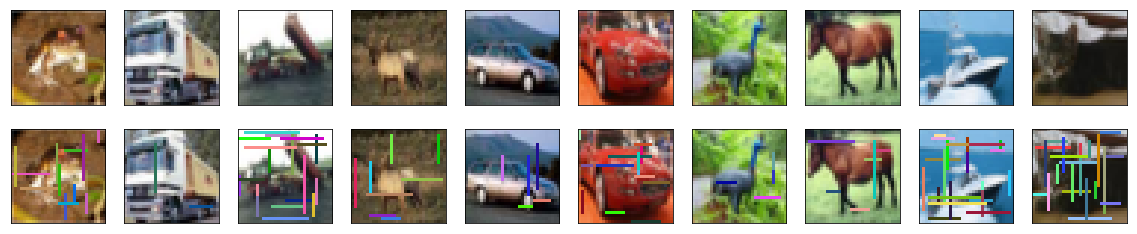

In [12]:
showOrigDec(x_train, x_train_line)

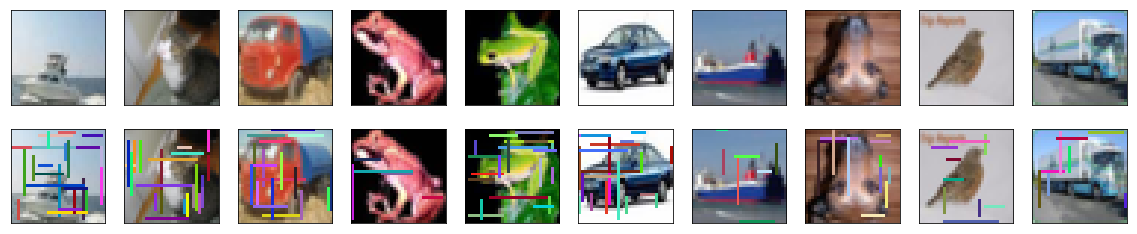

In [13]:
showOrigDec(x_train[100:], x_train_line[100:])

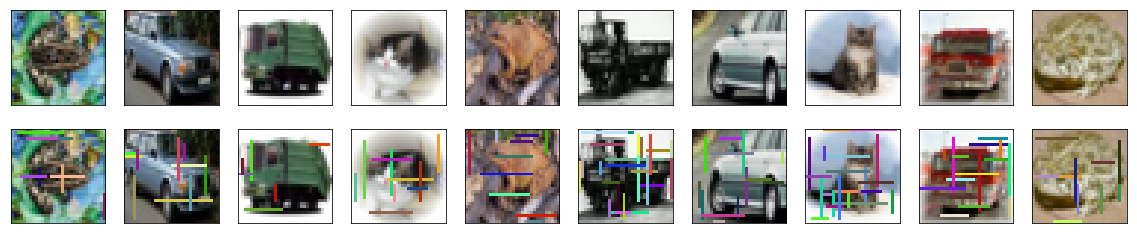

In [14]:
showOrigDec(x_train[200:], x_train_line[200:])

## Convolutional AutoEncoder for denoising

In [15]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Flatten()(x)
x = Dense(3072)(x)
x = BatchNormalization()(x)
encoded = Activation('sigmoid')(x)

In [16]:
x = Dense(3072)(encoded)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Reshape((32,32,3))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [17]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='mean_squared_error')

## Train AutoEncoder

In [18]:
# load pretrained weights
model.load_weights(saveDir + "AutoEncoder_Cifar10_deline_CAE_weights.17-0.00-0.00.hdf5")

In [19]:
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_deline_CAE_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [20]:
history = model.fit(x_train_line, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_line, x_test),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 193s - loss: 0.0111 - val_loss: 0.0068
Epoch 2/100
50000/50000 [==============================] - 192s - loss: 0.0063 - val_loss: 0.0050
Epoch 3/100
50000/50000 [==============================] - 186s - loss: 0.0052 - val_loss: 0.0043
Epoch 4/100
50000/50000 [==============================] - 186s - loss: 0.0046 - val_loss: 0.0037
Epoch 5/100
50000/50000 [==============================] - 186s - loss: 0.0041 - val_loss: 0.0036
Epoch 6/100
50000/50000 [==============================] - 186s - loss: 0.0037 - val_loss: 0.0035
Epoch 7/100
50000/50000 [==============================] - 186s - loss: 0.0035 - val_loss: 0.0034
Epoch 8/100
50000/50000 [==============================] - 186s - loss: 0.0032 - val_loss: 0.0030
Epoch 9/100
50000/50000 [==============================] - 185s - loss: 0.0030 - val_loss: 0.0035
Epoch 10/100
50000/50000 [==============================] - 186s - l

## Evaluate with test dataset

In [21]:
score = model.evaluate(x_test_line, x_test, verbose=1)
print(score)

10000/10000 [==============================] - 5s     
0.00257390149683


## Visualize original image, noisy image and denoised image

In [22]:
c10test = model.predict(x_test_line)

In [23]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

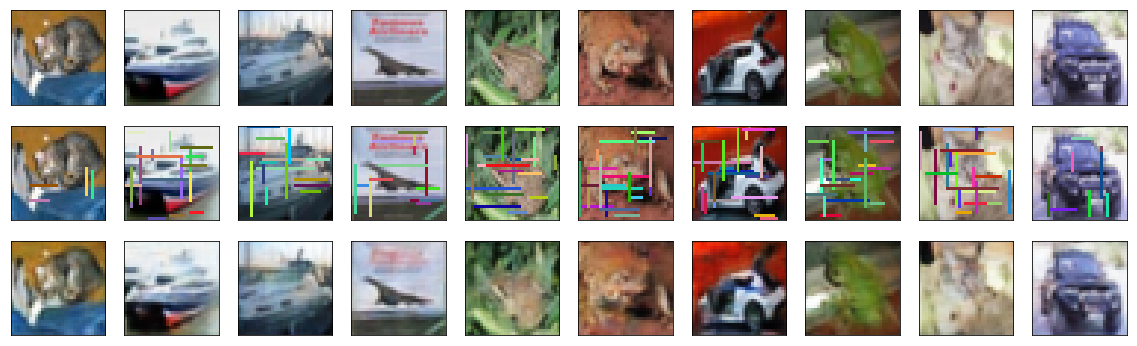

In [24]:
showOrigDec(x_test, x_test_line, c10test)

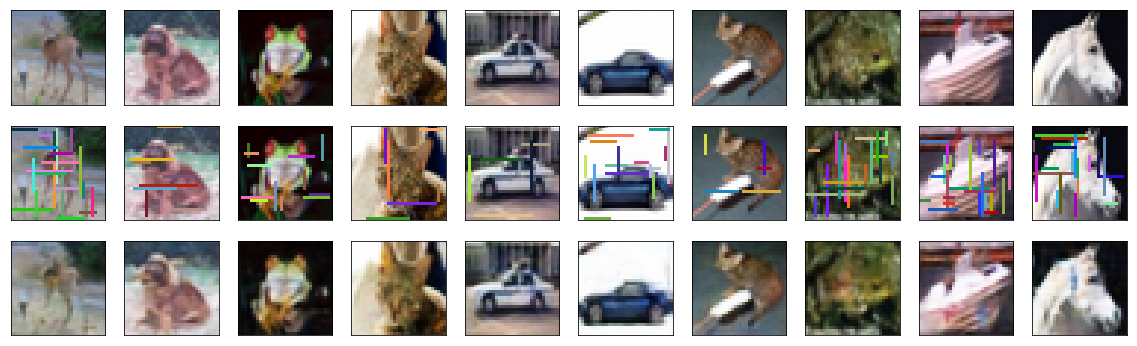

In [25]:
showOrigDec(x_test[100:], x_test_line[100:], c10test[100:])

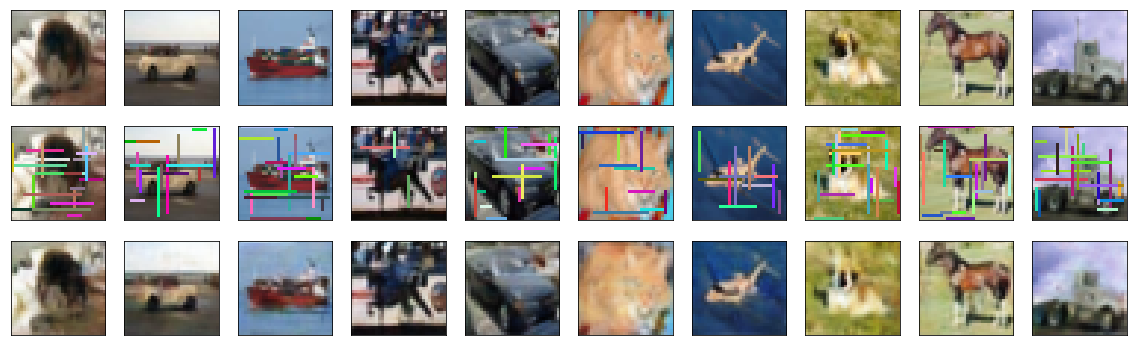

In [26]:
showOrigDec(x_test[200:], x_test_line[200:], c10test[200:])